<a href="https://colab.research.google.com/github/abinhack/ds_experiments/blob/main/MNSIT.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import torch 
import torchvision

In [2]:
n_epochs = 3 
batch_size_train = 64 
batch_size_test = 1000 
learning_rate = 0.01 
momentum = 0.5 
log_interval = 10 
random_seed = 1 
torch.backends.cudnn.enabled = False 
torch.manual_seed(random_seed)

In [4]:

train_loader = torch.utils.data.DataLoader( torchvision.datasets.MNIST('/files/',
                                              train=True, download=True,
                                              transform=torchvision.transforms.Compose([ torchvision.transforms.ToTensor(), torchvision.transforms.Normalize( (0.1307,), (0.3081,)) ])), 
                                           batch_size=batch_size_train, shuffle=True) 
test_loader = torch.utils.data.DataLoader( torchvision.datasets.MNIST('/files/', 
                                              train=False, download=True, 
                                              transform=torchvision.transforms.Compose([ torchvision.transforms.ToTensor(), torchvision.transforms.Normalize( (0.1307,), (0.3081,)) ])),
                                           batch_size=batch_size_test, shuffle=True)

Failed to download (trying next):
HTTP Error 503: Service Unavailable




Extracting /files/MNIST/raw/train-images-idx3-ubyte.gz to /files/MNIST/raw

Failed to download (trying next):
HTTP Error 503: Service Unavailable




Extracting /files/MNIST/raw/train-labels-idx1-ubyte.gz to /files/MNIST/raw

Failed to download (trying next):
HTTP Error 503: Service Unavailable




Extracting /files/MNIST/raw/t10k-images-idx3-ubyte.gz to /files/MNIST/raw

Failed to download (trying next):
HTTP Error 503: Service Unavailable




Extracting /files/MNIST/raw/t10k-labels-idx1-ubyte.gz to /files/MNIST/raw



/usr/local/lib/python3.7/dist-packages/torchvision/datasets/mnist.py:498: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:180.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


In [5]:
examples = enumerate(test_loader) 
batch_idx, (example_data, example_targets) = next(examples)

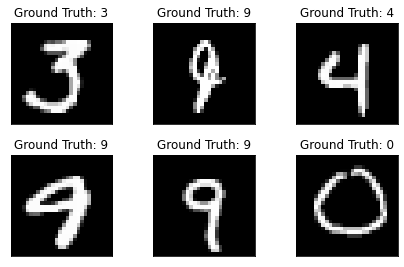

In [7]:
import matplotlib.pyplot as plt 
fig = plt.figure() 
for i in range(6): 
  plt.subplot(2,3,i+1) 
  plt.tight_layout() 
  plt.imshow(example_data[i][0], cmap='gray', interpolation='none') 
  plt.title("Ground Truth: {}".format(example_targets[i])) 
  plt.xticks([]) 
  plt.yticks([]) 
  fig

In [9]:
import torch.nn as nn 
import torch.nn.functional as F 
import torch.optim as optim

In [10]:
class Net(nn.Module): 
  def __init__(self): 
    super(Net, self).__init__() 
    self.conv1 = nn.Conv2d(1, 10, kernel_size=5) 
    self.conv2 = nn.Conv2d(10, 20, kernel_size=5) 
    self.conv2_drop = nn.Dropout2d() 
    self.fc1 = nn.Linear(320, 50) 
    self.fc2 = nn.Linear(50, 10) 
  def forward(self, x): 
    x = F.relu(F.max_pool2d(self.conv1(x), 2))
    x = F.relu(F.max_pool2d(self.conv2_drop(self.conv2(x)), 2)) 
    x = x.view(-1, 320) 
    x = F.relu(self.fc1(x)) 
    x = F.dropout(x, training=self.training) 
    x = self.fc2(x) 
    return F.log_softmax(x)

In [19]:
network = Net() 
optimizer = optim.SGD(network.parameters(), lr=learning_rate, momentum=momentum)

In [11]:
train_losses = [] 
train_counter = [] 
test_losses = [] 
test_counter = [i*len(train_loader.dataset) for i in range(n_epochs + 1)]

In [21]:
def train(epoch): 
  network.train() 
  for batch_idx, (data, target) in enumerate(train_loader): 
    optimizer.zero_grad() 
    output = network(data) 
    loss = F.nll_loss(output, target) 
    loss.backward() 
    optimizer.step() 
    if batch_idx % log_interval == 0: 
      print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format( epoch, batch_idx * len(data), len(train_loader.dataset), 100. * batch_idx / len(train_loader), loss.item())) 
      train_losses.append(loss.item()) 
      train_counter.append( (batch_idx*64) + ((epoch-1)*len(train_loader.dataset))) 
      torch.save(network.state_dict(), 'model.pth') 
      torch.save(optimizer.state_dict(), 'optimizer.pth')

In [22]:
def test(): 
  network.eval() 
  test_loss = 0 
  correct = 0 
  with torch.no_grad(): 
    for data, target in test_loader: 
      output = network(data) 
      test_loss += F.nll_loss(output, target, size_average=False).item() 
      pred = output.data.max(1, keepdim=True)[1] 
      correct += pred.eq(target.data.view_as(pred)).sum() 
      test_loss /= len(test_loader.dataset) 
      test_losses.append(test_loss) 
      print('\nTest set: Avg. loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format( test_loss, correct, len(test_loader.dataset), 100. * correct / len(test_loader.dataset)))

In [23]:
test() 
for epoch in range(1, n_epochs + 1): 
  train(epoch) 
  test()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  app.launch_new_instance()
/usr/local/lib/python3.7/dist-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))



Test set: Avg. loss: 0.2310, Accuracy: 88/10000 (1%)


Test set: Avg. loss: 0.2305, Accuracy: 197/10000 (2%)


Test set: Avg. loss: 0.2307, Accuracy: 289/10000 (3%)


Test set: Avg. loss: 0.2306, Accuracy: 375/10000 (4%)


Test set: Avg. loss: 0.2310, Accuracy: 460/10000 (5%)


Test set: Avg. loss: 0.2312, Accuracy: 546/10000 (5%)


Test set: Avg. loss: 0.2308, Accuracy: 646/10000 (6%)


Test set: Avg. loss: 0.2310, Accuracy: 749/10000 (7%)


Test set: Avg. loss: 0.2313, Accuracy: 826/10000 (8%)


Test set: Avg. loss: 0.2304, Accuracy: 923/10000 (9%)

Train Epoch: 1 [0/60000 (0%)]	Loss: 2.324247
Train Epoch: 1 [640/60000 (1%)]	Loss: 2.273413
Train Epoch: 1 [1280/60000 (2%)]	Loss: 2.252027
Train Epoch: 1 [1920/60000 (3%)]	Loss: 2.279411
Train Epoch: 1 [2560/60000 (4%)]	Loss: 2.259859
Train Epoch: 1 [3200/60000 (5%)]	Loss: 2.255871
Train Epoch: 1 [3840/60000 (6%)]	Loss: 2.175713
Train Epoch: 1 [4480/60000 (7%)]	Loss: 2.212805
Train Epoch: 1 [5120/60000 (9%)]	Loss: 2.093185
Train Epoch: 

Performance checking

ValueError: ignored

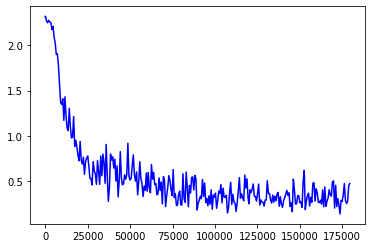

In [24]:
fig = plt.figure()
plt.plot(train_counter, train_losses, color='blue')
plt.scatter(test_counter, test_losses, color='red')
plt.legend(['Train Loss', 'Test Loss'], loc='upper right')
plt.xlabel('number of training examples seen')
plt.ylabel('negative log likelihood loss')
fig


